# Predicting Traffic Signs using Convolutional Neural Network (CNN).

In [2]:
# from google.colab import drive
# drive.mount('/content/drive/')

# %cd /content/drive/My Drive/Datasets/Traffic Sign Images

Mounted at /content/drive/
/content/drive/My Drive/Datasets/Traffic Sign Images


Importing all the required files and the libraries

In [1]:
## importing all the necessary functions stored in the .py files

from DataPreprocess import read_file, load_dataset
from data_augmentation import augmentation
from CNN_model import convolution_layer, fully_dense_layer
from Inception import inception_layer
from ResNet import identity_block, convulation_block

In [44]:
## importing all the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Conv2D, Dense,MaxPooling2D, Activation, BatchNormalization, Dropout, Flatten, Input, ZeroPadding2D

## Loading and Preparing Images for the CNN.

* Load the training images. Images are stored in the pickle file.


* EDA
    - Visualize the images randomly.
    - Check the class balance in the dataset.


* Now load the preprocessed dataset. It will

    - Convert the datatype of images and their corresponding labels to numpy arrays. 
    - Shuffle the dataset.
    - Split the training dataset into a training and validation datasets.
    - Normalize the images to a range of [0,1].
    - One hot encode the labels.


* Data Augmentation
    - Distort the images along an axis using shear range.
    - Zoom in and out using the zoom range.

In [4]:
# read and visualize training data
X_train, y_train = read_file('../Data/train.pkl')

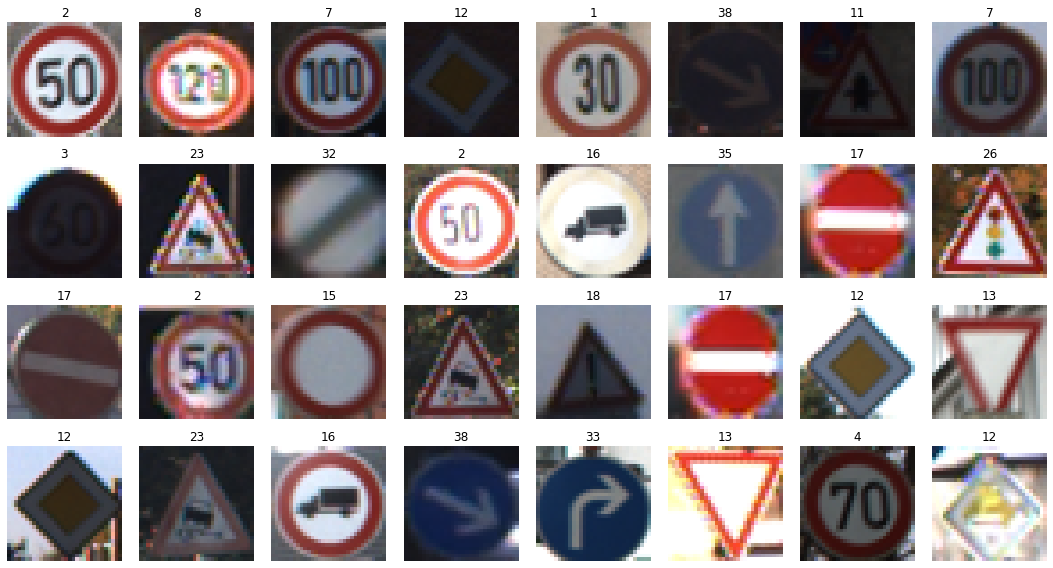

In [5]:
# visualizing the training data
plt.figure(figsize=(15,8))
for i in range(32):
    plt.subplot(4,8,i+1)
    ind_ = np.random.randint(0,X_train.shape[0])
    plt.imshow(X_train[ind_])
    plt.title(y_train[ind_])
    plt.axis('off')
    plt.tight_layout()

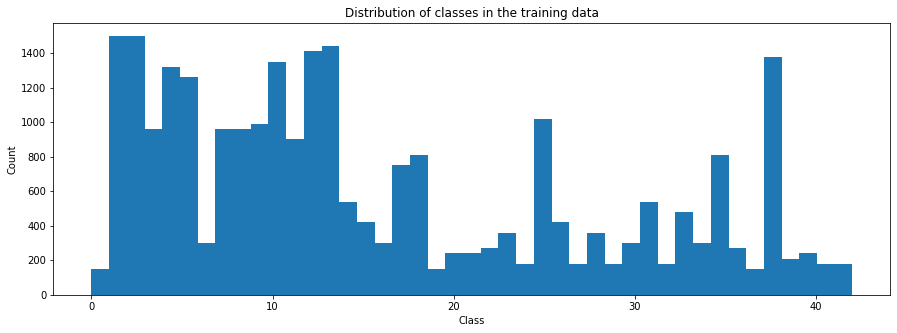

In [6]:
# visualizing the distribution of classes in the training data
plt.figure(figsize=(15,5))
plt.hist(y_train, bins=43)
plt.title('Distribution of classes in the training data')
plt.xlabel('Class')
plt.ylabel('Count');

### Loading Preprocessed Data

In [9]:
signnames, scaled_train, one_hot_train, scaled_valid, one_hot_valid, scaled_test, one_hot_test = load_dataset()

In [10]:
signnames.head()

0    Speed limit (20km/h)
1    Speed limit (30km/h)
2    Speed limit (50km/h)
3    Speed limit (60km/h)
4    Speed limit (70km/h)
Name: SignName, dtype: object

### Data Augmentation

In [11]:
# this function returns a generator 
batch_size = 64
train_generator = augmentation(scaled_train, one_hot_train, batch_size)

In [12]:
print('Shape of X_train in the 1st Batch == {}'.format(train_generator[0][0].shape))

Shape of X_train in the 1st Batch == (64, 32, 32, 3)


In [13]:
# Preparing callbacks and optimizer before creating the model

## CNN

Create a function that will apply callback and optimizer to the models.

In [14]:
reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, verbose=1, patience=3)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

### Creating a CNN with 8 layers.

In [16]:
def build_cnn(shape_=(32,32,3), classes=43):
  x_in = Input(shape_)
  x = x_in
  x = convolution_layer(x, 64, 0.2)
  x = convolution_layer(x, 128, 0.3)
  x = convolution_layer(x, 256, 0.4)


  x = Flatten()(x)
  x = fully_dense_layer(x, 128, 0.2)
  x_output = Dense(classes, activation='softmax')(x)
  model = Model(inputs = x_in, outputs = x_output, name='model')
  return model

In [17]:
cnn_model = build_cnn()

In [18]:
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                             

In [19]:
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
epochs = 5

history = cnn_model.fit(
    train_generator, 
    steps_per_epoch=scaled_train.shape[0] // batch_size, 
    epochs=epochs,  
    validation_data=(scaled_valid, one_hot_valid), 
    callbacks=[reduce_learning_rate, early_stopping],
    verbose=1
)

Epoch 1/5
333/333 [==============================] - 32s 61ms/step - loss: 1.8774 - accuracy: 0.5156 - val_loss: 1.0606 - val_accuracy: 0.7459 - lr: 0.0010
Epoch 2/5
333/333 [==============================] - 20s 59ms/step - loss: 0.5219 - accuracy: 0.8840 - val_loss: 0.2279 - val_accuracy: 0.9617 - lr: 0.0010
Epoch 3/5
333/333 [==============================] - 20s 59ms/step - loss: 0.3244 - accuracy: 0.9395 - val_loss: 0.1503 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 4/5
333/333 [==============================] - 19s 58ms/step - loss: 0.2621 - accuracy: 0.9576 - val_loss: 0.1316 - val_accuracy: 0.9940 - lr: 0.0010
Epoch 5/5
333/333 [==============================] - 20s 60ms/step - loss: 0.2376 - accuracy: 0.9625 - val_loss: 0.1458 - val_accuracy: 0.9889 - lr: 0.0010


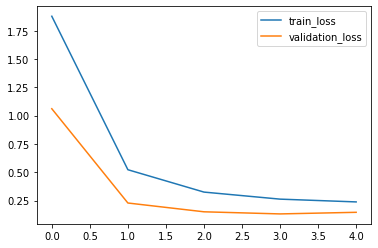

In [21]:
plt.plot(cnn_model.history.history['loss'], label='train_loss')
plt.plot(cnn_model.history.history['val_loss'], label = 'validation_loss')
plt.legend();


In [22]:
cnn_acc = np.round(cnn_model.evaluate(scaled_test, one_hot_test)[1]*100,2)
print('Accuracy of our 8 Layer CNN model is {}%'.format(cnn_acc))

395/395 [==============================] - 4s 11ms/step - loss: 0.2263 - accuracy: 0.9609
Accuracy of our 8 Layer CNN model is 96.09%


### Building a Resnet Model


In [23]:
def build_resnet(shape_ = (32, 32, 3), classes = 43):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(shape_)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
   
    # Stage 2
    X = convulation_block(X,  filters = [64,64,256],f=3,s=2)
    X = identity_block(X,  [64,64,256], 3)
    X = identity_block(X,  [64,64,256], 3)


    # Stage 3 
    X = convulation_block(X,  filters = [128,128,512],f=3,s=1)
    X = identity_block(X,  [128,128,512], 3)

    X = MaxPooling2D(pool_size=(2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [24]:
resnet_model = build_resnet()

In [25]:
resnet_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 16, 16, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 16, 16, 64)  256         ['conv2d_6[0][0]']               
 rmalization)                                                                              

In [26]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
history = resnet_model.fit(
    train_generator, 
    steps_per_epoch=scaled_train.shape[0] // batch_size, 
    epochs=epochs,  
    validation_data=(scaled_valid, one_hot_valid), 
    callbacks=[reduce_learning_rate, early_stopping],
    verbose=1
)

Epoch 1/5
333/333 [==============================] - 26s 64ms/step - loss: 3.2330 - accuracy: 0.3628 - val_loss: 1.8847 - val_accuracy: 0.5495 - lr: 0.0010
Epoch 2/5
333/333 [==============================] - 20s 60ms/step - loss: 0.8990 - accuracy: 0.7686 - val_loss: 0.6742 - val_accuracy: 0.8562 - lr: 0.0010
Epoch 3/5
333/333 [==============================] - 21s 63ms/step - loss: 0.5118 - accuracy: 0.8749 - val_loss: 0.2437 - val_accuracy: 0.9407 - lr: 0.0010
Epoch 4/5
333/333 [==============================] - 20s 60ms/step - loss: 0.3905 - accuracy: 0.9147 - val_loss: 0.1289 - val_accuracy: 0.9773 - lr: 0.0010
Epoch 5/5
333/333 [==============================] - 20s 60ms/step - loss: 0.2674 - accuracy: 0.9397 - val_loss: 0.1306 - val_accuracy: 0.9698 - lr: 0.0010


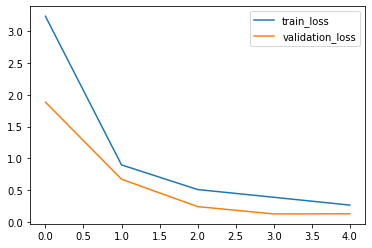

In [28]:
plt.plot(resnet_model.history.history['loss'], label='train_loss')
plt.plot(resnet_model.history.history['val_loss'], label = 'validation_loss')
plt.legend();

In [29]:
resnet_acc = np.round(resnet_model.evaluate(scaled_test, one_hot_test)[1]*100,2)
print('Accuracy of our Resnet model is {}%'.format(resnet_acc))

395/395 [==============================] - 5s 12ms/step - loss: 0.3812 - accuracy: 0.9021
Accuracy of our Resnet model is 90.21%


### Building an Inception model


In [30]:
def build_inception(shape_ = (32,32,3), classes=43):
  X_input = Input(shape_)
  
  X = Conv2D(16, 3,padding='valid')(X_input)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(32, 3, padding='valid')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(64, 3, strides = (2,2), padding='valid')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Dropout(0.2)(X)
  X = inception_layer(X, 256)
  X = inception_layer(X, 256 , True)

  X = Conv2D(256, 3, strides = (2,2), padding='valid')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = Dropout(0.3)(X)

  X = MaxPooling2D(pool_size=(2,2), strides=(1,1))(X)

  X = Flatten()(X)

  # two fully dense layers with 128 units and 0 dropout
  X = fully_dense_layer(X, 128, 0)
  X = fully_dense_layer(X, 128, 0)

  X_output = Dense(classes, activation='softmax')(X)
  model = Model(X_input, X_output, name='InceptionNetwork')

  return model

In [31]:
inception_model = build_inception()

In [32]:
inception_model.summary()

Model: "InceptionNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_24 (Conv2D)             (None, 30, 30, 16)   448         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_25 (BatchN  (None, 30, 30, 16)  64          ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_23 (Activation)     (None, 30, 30, 16)   0           ['batch_normalizat

In [33]:
inception_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [34]:
history = inception_model.fit(
    train_generator, 
    steps_per_epoch=scaled_train.shape[0] // batch_size, 
    epochs=epochs,  
    validation_data=(scaled_valid, one_hot_valid), 
    callbacks=[reduce_learning_rate, early_stopping],
    verbose=1
)

Epoch 1/5
333/333 [==============================] - 85s 241ms/step - loss: 1.6029 - accuracy: 0.5470 - val_loss: 1.2263 - val_accuracy: 0.6441 - lr: 0.0010
Epoch 2/5
333/333 [==============================] - 83s 250ms/step - loss: 0.3075 - accuracy: 0.9093 - val_loss: 0.1188 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 3/5
333/333 [==============================] - 79s 238ms/step - loss: 0.1550 - accuracy: 0.9561 - val_loss: 0.0485 - val_accuracy: 0.9886 - lr: 0.0010
Epoch 4/5
333/333 [==============================] - 79s 238ms/step - loss: 0.1139 - accuracy: 0.9658 - val_loss: 0.0473 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 5/5
333/333 [==============================] - 79s 237ms/step - loss: 0.0851 - accuracy: 0.9751 - val_loss: 0.0487 - val_accuracy: 0.9865 - lr: 0.0010


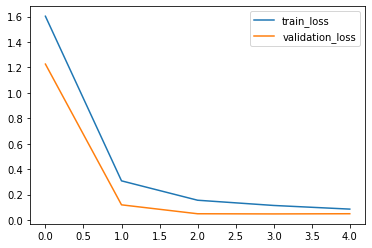

In [35]:
plt.plot(inception_model.history.history['loss'], label='train_loss')
plt.plot(inception_model.history.history['val_loss'], label = 'validation_loss')
plt.legend();

In [36]:
inception_acc = np.round(inception_model.evaluate(scaled_test, one_hot_test)[1]*100,2)
print('Accuracy of our Inception model is {}%'.format(inception_acc))

395/395 [==============================] - 16s 40ms/step - loss: 0.1864 - accuracy: 0.9472
Accuracy of our Inception model is 94.72%


### Evaluating the performances of all the models.

* Choose the model that outperforms the others on the testing dataset.
* Evaluate the performance of the chosen model by:
    - displaying confusion matrix.
    - displaying classification report.
    - visualizing random predictions.
* Lastly, save the chosen model.

In [37]:
pd.DataFrame({'Models': ['8 Layer CNN model','ResNet model','Inception model' ], 'Accuracies': [cnn_acc, resnet_acc, inception_acc]})

,Models,Accuracies
0,8 Layer CNN model,96.09
1,ResNet model,90.21
2,Inception model,94.72


It appear that the CNN with 8 layes performed the best, hence we'll proceed with it.

In [58]:
y_test = np.argmax(one_hot_test,axis=1)
ypred = np.argmax(cnn_model.predict(scaled_test), axis=1)

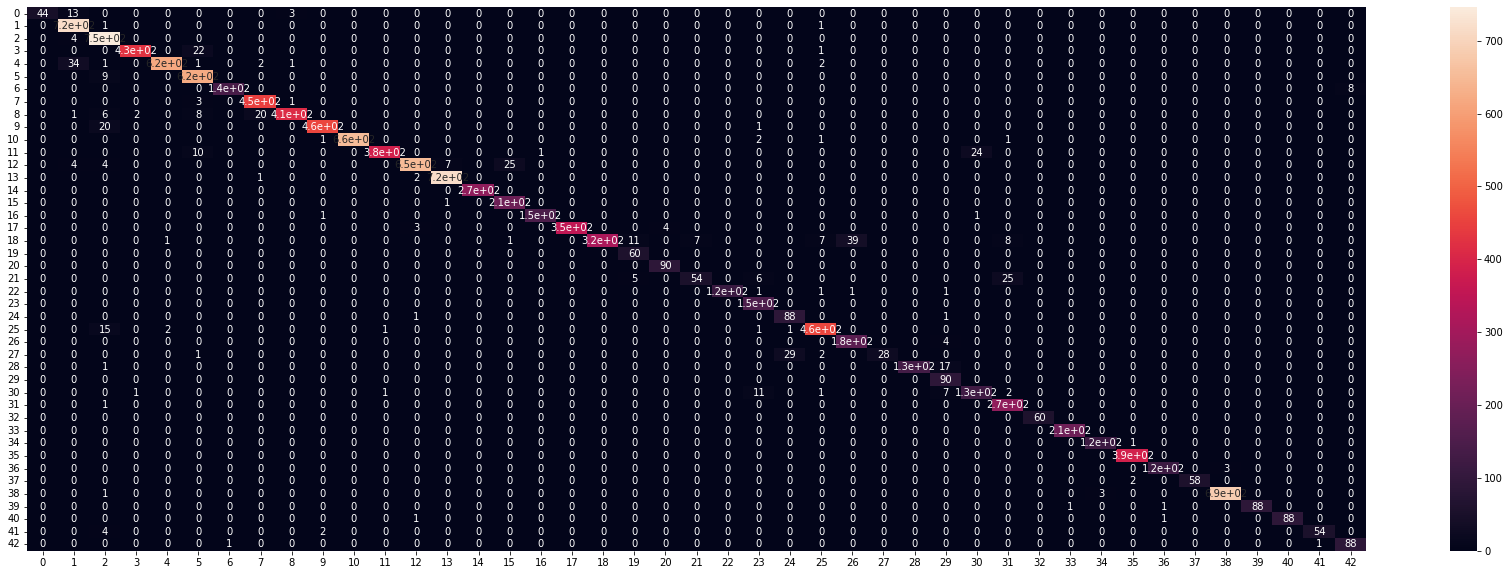

In [59]:
from sklearn.metrics import confusion_matrix, classification_report
plt.figure(figsize=(30,10))
sns.heatmap(confusion_matrix(y_test, ypred), annot=True)


##### Randomly Visualizing the Test dataset results

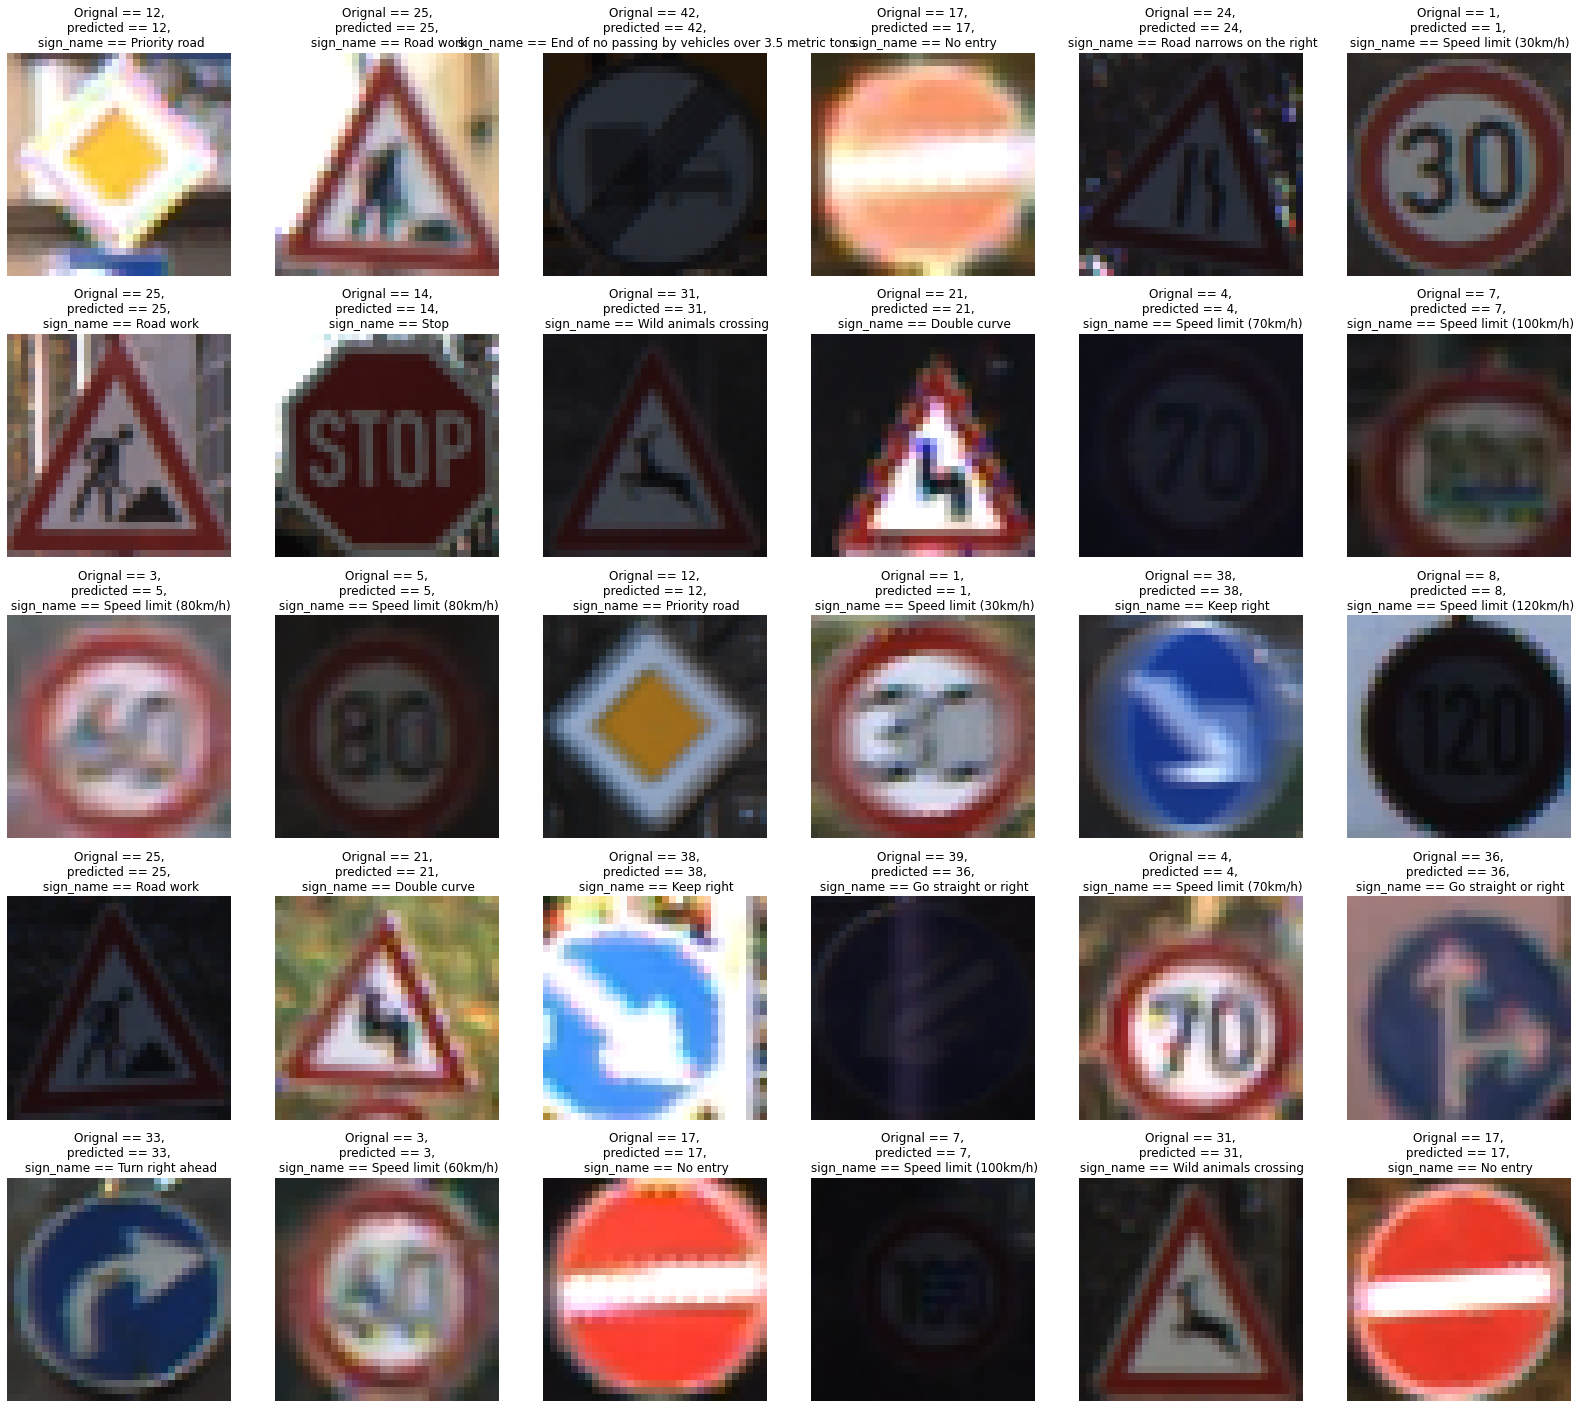

In [64]:

plt.figure(figsize=(28,25))
for i in range(30):
    plt.subplot(5,6,i+1)
    ind_ = np.random.randint(0, X_test.shape[0])
    plt.imshow((scaled_test*255)[ind_].astype('uint8'))
    y_test_ind = y_test[ind_]
    ypred_ind = ypred[ind_]
    plt.title('Orignal == {},\n predicted == {}, \n sign_name == {}'.format(y_test_ind, ypred_ind, signnames[ypred_ind]))
    plt.axis('off')


In [61]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        60
           1       0.93      1.00      0.96       720
           2       0.92      0.99      0.96       750
           3       0.99      0.95      0.97       450
           4       1.00      0.94      0.97       660
           5       0.93      0.99      0.96       630
           6       0.99      0.95      0.97       150
           7       0.95      0.99      0.97       450
           8       0.99      0.92      0.95       450
           9       0.99      0.96      0.97       480
          10       1.00      0.99      1.00       660
          11       0.99      0.92      0.95       420
          12       0.99      0.94      0.97       690
          13       0.99      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.89      1.00      0.94       210
          16       0.99      0.99      0.99       150
          17       1.00    

##### Save the model


In [62]:
cnn_model.save('../saved_models/best_model.h5')